In [345]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import importlib


In [357]:
class BranchingQNetwork(nn.Module):
    def __init__(self, observation_space, action_space, action_bins, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(observation_space, hidden_dim),
            nn.ReLu(dim=1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softmax(dim=1)
        )

        self.value_head = nn.Linear(hidden_dim, 1)
        self.adv_heads = nn.ModuleList([nn.Linear(hidden_dim, action_bins) for i in range(action_space)])

    def forward(self, x):
        out = self.model(x)
        value = self.value_head(out)
        advs = torch.stack([l(out) for l in self.adv_heads], dim=0)

        q_val = value + advs - advs.mean(1, keepdim=True)

    
        return q_val

In [231]:
a =  torch.randn(4,4)
a

tensor([[-0.0803,  1.0562, -0.6438,  0.2732],
        [-0.5208,  1.5778, -0.4955, -2.3266],
        [ 1.0256, -0.3160,  0.2334,  1.0341],
        [ 1.6443,  0.4534,  1.5221, -0.3710]])

In [232]:
a.mean(1, keepdim=True)

tensor([[ 0.1513],
        [-0.4413],
        [ 0.4943],
        [ 0.8122]])

In [233]:
obs = torch.rand(105)
obs

tensor([0.4577, 0.1391, 0.2264, 0.7035, 0.2328, 0.5097, 0.3276, 0.9801, 0.0170,
        0.0773, 0.0616, 0.2030, 0.0624, 0.2489, 0.4335, 0.4331, 0.0136, 0.0306,
        0.9976, 0.9873, 0.5061, 0.4616, 0.2190, 0.1559, 0.6890, 0.8573, 0.6443,
        0.7138, 0.3458, 0.5469, 0.7242, 0.6431, 0.9018, 0.7880, 0.2407, 0.6155,
        0.9322, 0.8676, 0.4110, 0.7266, 0.5988, 0.5296, 0.1269, 0.2742, 0.8562,
        0.4676, 0.7502, 0.7614, 0.5652, 0.0517, 0.4601, 0.3504, 0.3273, 0.7815,
        0.8327, 0.3813, 0.4663, 0.7940, 0.1716, 0.7857, 0.5550, 0.7735, 0.5599,
        0.2586, 0.6407, 0.1815, 0.4640, 0.1427, 0.1377, 0.9719, 0.1992, 0.4773,
        0.8524, 0.4671, 0.7244, 0.8844, 0.3963, 0.4151, 0.9834, 0.4299, 0.0089,
        0.8533, 0.7134, 0.6366, 0.0249, 0.9753, 0.4386, 0.3942, 0.3519, 0.1393,
        0.9888, 0.2480, 0.0884, 0.0552, 0.1346, 0.9014, 0.5243, 0.5459, 0.5815,
        0.7839, 0.2611, 0.0865, 0.6511, 0.3480, 0.6953])

In [234]:
obs.shape

torch.Size([105])

In [235]:
action = torch.randn(7,2)
action.shape[0]

7

In [236]:
value = torch.randn(1)
value


tensor([-0.7830])

In [237]:
value.unsqueeze(1)

tensor([[-0.7830]])

In [238]:
policy = BranchingQNetwork(obs.shape[0], 7, 132, 128)
target = BranchingQNetwork(obs.shape[0], 7, 132, 128)


In [239]:
target.load_state_dict(policy.state_dict())

<All keys matched successfully>

In [240]:
learning_rate = 1e-4
optim = optim.Adam(policy.parameters(), lr=learning_rate)



In [241]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [242]:
optim.zero_grad()


In [243]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

In [244]:
states = torch.randn(105)
action = torch.randint(0, 132, (7,))
reward = 0
next_states = torch.randn(105)



In [245]:
current_q = policy(states)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [246]:
action

tensor([128,  58,  30,  27,  31,  52,  78])

In [247]:
action.unsqueeze(1)

tensor([[128],
        [ 58],
        [ 30],
        [ 27],
        [ 31],
        [ 52],
        [ 78]])

In [248]:
current_q = current_q.gather(1, action.unsqueeze(1)).squeeze(-1)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [249]:
current_q

tensor([ 0.0222, -0.0738,  0.1298,  0.1923, -0.0607,  0.0206,  0.1943],
       grad_fn=<SqueezeBackward1>)

In [250]:
argmax = torch.argmax(policy(next_states), dim = 1)
argmax

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [251]:
max_next_Q = target(next_states).gather(1, argmax.unsqueeze(1)).squeeze(-1)
max_next_Q

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [138]:
max_next_Q = max_next_Q.mean(0, keepdim= True)
max_next_Q

tensor([0.3385], grad_fn=<MeanBackward1>)

In [139]:
gamma = 0.9
expected_Q = reward + max_next_Q * gamma
expected_Q

tensor([0.3047], grad_fn=<AddBackward0>)

In [140]:
current_q

tensor([ 0.0222, -0.0738,  0.1298,  0.1923, -0.0607,  0.0206,  0.1943],
       grad_fn=<SqueezeBackward1>)

In [141]:
loss = F.mse_loss(expected_Q, current_q)

In [142]:
loss

tensor(0.0704, grad_fn=<MseLossBackward>)

In [143]:
optim.zero_grad()

In [144]:
loss.backward()

In [145]:
for p in policy.parameters():
    print(p.grad.data.clamp_(-1.,1.))

tensor([[-1.6957e-02,  1.7050e-02,  1.7803e-02,  ...,  2.1500e-04,
         -2.5950e-02, -1.5482e-02],
        [-1.1783e-02,  1.1847e-02,  1.2370e-02,  ...,  1.4939e-04,
         -1.8031e-02, -1.0758e-02],
        [ 2.3947e-03, -2.4078e-03, -2.5141e-03,  ..., -3.0362e-05,
          3.6646e-03,  2.1864e-03],
        ...,
        [-0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00, -0.0000e+00],
        [-1.4591e-02,  1.4671e-02,  1.5318e-02,  ...,  1.8499e-04,
         -2.2328e-02, -1.3321e-02],
        [ 5.5563e-03, -5.5866e-03, -5.8333e-03,  ..., -7.0446e-05,
          8.5027e-03,  5.0728e-03]])
tensor([ 1.7696e-02,  1.2296e-02, -2.4991e-03, -1.4139e-02,  0.0000e+00,
         2.0580e-03,  0.0000e+00, -6.6366e-04,  0.0000e+00,  0.0000e+00,
        -3.2719e-03,  3.9778e-03,  1.1279e-02, -2.6162e-04,  7.3630e-03,
         0.0000e+00,  5.7510e-03,  6.5469e-03,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -9.0092e-04,  3.5018e-03,  0.0000e+00, -9.4276e-03,
   

In [146]:
loss.detach().numpy()

array(0.07035503, dtype=float32)

In [147]:
np.linspace(-1,1,132)

array([-1.        , -0.98473282, -0.96946565, -0.95419847, -0.9389313 ,
       -0.92366412, -0.90839695, -0.89312977, -0.8778626 , -0.86259542,
       -0.84732824, -0.83206107, -0.81679389, -0.80152672, -0.78625954,
       -0.77099237, -0.75572519, -0.74045802, -0.72519084, -0.70992366,
       -0.69465649, -0.67938931, -0.66412214, -0.64885496, -0.63358779,
       -0.61832061, -0.60305344, -0.58778626, -0.57251908, -0.55725191,
       -0.54198473, -0.52671756, -0.51145038, -0.49618321, -0.48091603,
       -0.46564885, -0.45038168, -0.4351145 , -0.41984733, -0.40458015,
       -0.38931298, -0.3740458 , -0.35877863, -0.34351145, -0.32824427,
       -0.3129771 , -0.29770992, -0.28244275, -0.26717557, -0.2519084 ,
       -0.23664122, -0.22137405, -0.20610687, -0.19083969, -0.17557252,
       -0.16030534, -0.14503817, -0.12977099, -0.11450382, -0.09923664,
       -0.08396947, -0.06870229, -0.05343511, -0.03816794, -0.02290076,
       -0.00763359,  0.00763359,  0.02290076,  0.03816794,  0.05

In [148]:
torch.cuda.init()

In [149]:
import sys

In [153]:
from agents import random_actions

In [161]:
obs

tensor([0.0830, 0.4124, 0.4551, 0.7671, 0.0220, 0.4815, 0.2063, 0.5051, 0.8469,
        0.2096, 0.1656, 0.3348, 0.3794, 0.9347, 0.0801, 0.8967, 0.5704, 0.4535,
        0.9292, 0.8787, 0.2121, 0.5989, 0.2332, 0.0244, 0.9013, 0.7997, 0.6940,
        0.7609, 0.8513, 0.6706, 0.0253, 0.6127, 0.6415, 0.1296, 0.7249, 0.2447,
        0.2483, 0.6806, 0.7105, 0.8748, 0.1033, 0.2845, 0.3112, 0.0772, 0.6148,
        0.7666, 0.8586, 0.1589, 0.7170, 0.4426, 0.6796, 0.2370, 0.0555, 0.4510,
        0.4587, 0.8502, 0.9431, 0.6341, 0.3209, 0.5310, 0.6800, 0.8095, 0.9145,
        0.7502, 0.0820, 0.5155, 0.4397, 0.9034, 0.8119, 0.5759, 0.9849, 0.4811,
        0.5467, 0.0479, 0.0401, 0.5424, 0.8481, 0.5568, 0.9336, 0.9873, 0.4090,
        0.0657, 0.2453, 0.9925, 0.8555, 0.5105, 0.5742, 0.5474, 0.4210, 0.2494,
        0.4915, 0.3038, 0.9954, 0.0177, 0.0111, 0.5225, 0.8991, 0.8292, 0.3535,
        0.5642, 0.4810, 0.2727, 0.1918, 0.4364, 0.1598])

In [209]:
value = torch.randn((64,1))
value

tensor([[-1.9976],
        [-1.1203],
        [ 0.2147],
        [-0.0185],
        [ 0.2793],
        [ 1.1793],
        [ 0.6820],
        [ 0.6447],
        [-0.3260],
        [ 1.2579],
        [ 1.2375],
        [-0.0345],
        [ 0.3433],
        [-0.8174],
        [-0.9680],
        [-0.1885],
        [ 2.0348],
        [ 0.0435],
        [-0.4866],
        [-0.9170],
        [-0.7190],
        [-0.8577],
        [ 1.2513],
        [ 0.9863],
        [-0.3322],
        [ 1.3322],
        [ 0.6440],
        [-0.3353],
        [ 0.7583],
        [ 0.9740],
        [ 0.8674],
        [-0.6346],
        [ 1.6965],
        [ 0.7996],
        [ 1.5226],
        [ 0.3301],
        [ 0.8336],
        [ 1.0484],
        [ 0.8192],
        [ 0.7407],
        [-0.3717],
        [-0.7547],
        [-1.0736],
        [ 0.6281],
        [ 0.9393],
        [ 0.2530],
        [ 0.5603],
        [-0.2607],
        [ 1.5920],
        [-0.9475],
        [ 1.5873],
        [ 1.2639],
        [ 0.

In [210]:
advs = torch.randn((64,7,132))
advs

tensor([[[-1.2068, -1.8954,  0.7135,  ...,  0.6088,  1.2021,  0.2778],
         [-0.5118, -2.1357, -0.6352,  ..., -1.2942, -0.1597,  0.7676],
         [-1.6877,  1.0168, -0.1525,  ..., -0.0268, -0.2852, -1.5458],
         ...,
         [ 0.7653,  0.1356, -0.0030,  ..., -0.1031,  0.3148, -1.7624],
         [-0.9435,  1.1407,  0.1247,  ...,  0.9815, -1.3269,  0.4010],
         [-0.5127, -1.4620, -0.8592,  ...,  0.1655,  1.0872,  1.7804]],

        [[ 1.0501, -0.4752, -0.6338,  ..., -1.9583, -1.1993, -1.3766],
         [ 0.3150,  0.6708, -1.4899,  ...,  1.0364,  0.6407, -1.2041],
         [ 0.1459, -0.0709, -1.1831,  ..., -0.2040,  2.2404, -0.9640],
         ...,
         [ 1.2132,  0.0829,  1.0483,  ..., -1.0633, -0.7850,  0.4201],
         [ 0.4292,  0.3170, -0.1012,  ..., -0.7528, -0.1740,  0.3959],
         [ 1.0836,  0.7134,  1.2918,  ...,  0.7371,  0.2850,  0.6737]],

        [[ 0.0396, -1.0044, -0.2219,  ..., -0.4046,  1.8610,  1.8611],
         [-0.4089,  0.2014,  0.5535,  ..., -0

In [211]:
value.unsqueeze(1).shape

torch.Size([64, 1, 1])

In [213]:
q = value.unsqueeze(1) + advs 


In [214]:
q.shape

torch.Size([64, 7, 132])

In [215]:
advs.mean(2, keepdim=True).shape

torch.Size([64, 7, 1])

In [216]:
q = value.unsqueeze(1) + advs - advs.mean(2, keepdim=True)
q

tensor([[[-3.2301, -3.9187, -1.3097,  ..., -1.4144, -0.8212, -1.7455],
         [-2.4812, -4.1052, -2.6046,  ..., -3.2636, -2.1292, -1.2018],
         [-3.7376, -1.0331, -2.2024,  ..., -2.0767, -2.3351, -3.5957],
         ...,
         [-1.2969, -1.9265, -2.0652,  ..., -2.1653, -1.7474, -3.8245],
         [-3.0152, -0.9309, -1.9469,  ..., -1.0901, -3.3985, -1.6706],
         [-2.7327, -3.6820, -3.0793,  ..., -2.0545, -1.1328, -0.4396]],

        [[ 0.0384, -1.4869, -1.6455,  ..., -2.9700, -2.2111, -2.3883],
         [-0.8923, -0.5365, -2.6972,  ..., -0.1709, -0.5665, -2.4114],
         [-0.9249, -1.1417, -2.2540,  ..., -1.2748,  1.1696, -2.0348],
         ...,
         [ 0.2436, -0.8867,  0.0787,  ..., -2.0329, -1.7547, -0.5495],
         [-0.7592, -0.8714, -1.2896,  ..., -1.9412, -1.3624, -0.7925],
         [-0.1113, -0.4815,  0.0970,  ..., -0.4577, -0.9099, -0.5212]],

        [[ 0.2998, -0.7442,  0.0384,  ..., -0.1444,  2.1212,  2.1213],
         [-0.1629,  0.4475,  0.7996,  ...,  0

In [252]:
o = torch.randn(1)

In [253]:
u = torch.randn((7,132))


In [254]:
t = o+u

In [255]:
t

tensor([[ 1.4819e+00, -1.3352e-01, -2.1356e-01, -1.0911e-01,  3.5015e-01,
         -8.1715e-01, -3.6989e-01, -5.2305e-01, -7.0415e-01, -1.9973e-01,
         -1.5695e-01, -1.0467e+00, -4.7138e-02, -1.7400e+00,  1.3744e-01,
         -1.3786e+00, -1.5015e+00,  1.5167e+00, -1.0429e+00, -1.1815e+00,
          1.0425e+00, -1.4569e+00,  1.1000e+00, -2.3858e-01, -2.0129e+00,
         -3.2355e-01,  6.7169e-01, -6.2313e-01,  2.6437e-01, -8.8893e-01,
         -4.3484e-01,  5.4433e-01, -1.7005e-01, -4.9023e-02, -7.5233e-01,
          1.9230e+00, -9.0301e-01, -8.6664e-01, -2.3282e+00,  1.4146e+00,
         -1.9020e+00, -1.2407e+00, -1.1215e+00, -1.2402e+00,  1.1807e+00,
         -2.0173e+00, -1.6553e+00, -9.1408e-01, -3.9930e-01, -5.3499e-01,
          9.0881e-01, -2.2047e+00,  1.1509e+00, -1.5209e+00, -2.5986e-01,
          1.8174e+00, -8.7037e-01, -1.9622e+00,  2.7286e-01, -1.5236e-01,
          7.3695e-02, -3.1806e-01, -5.8360e-04,  2.0717e-01,  7.3171e-01,
          3.6343e-01, -5.5504e-01, -4.

In [256]:
t.shape

torch.Size([7, 132])

In [257]:
t = o + u - u.mean(1, keepdim=True)

In [258]:
t.shape

torch.Size([7, 132])

In [261]:
gg = torch.argmax(t, dim=1)

In [262]:
gg.shape

torch.Size([7])

In [263]:
val = torch.randn((64,1))
val

tensor([[-0.3761],
        [ 0.6314],
        [ 1.0508],
        [ 0.0951],
        [ 0.2832],
        [ 0.8200],
        [-1.0022],
        [-0.4210],
        [-1.3799],
        [-1.3393],
        [-0.8460],
        [ 1.0477],
        [ 0.3984],
        [ 0.3186],
        [-0.0117],
        [-1.3863],
        [ 1.7818],
        [-0.2634],
        [ 0.0590],
        [ 0.4212],
        [-0.4254],
        [ 1.9993],
        [-0.6950],
        [ 0.5532],
        [ 0.5301],
        [ 1.9315],
        [-0.4562],
        [-0.4331],
        [-1.5994],
        [ 0.3790],
        [-1.6409],
        [ 0.0164],
        [ 0.9149],
        [ 1.0521],
        [ 1.4440],
        [-1.9536],
        [-0.1121],
        [-1.6445],
        [-0.2234],
        [ 1.3067],
        [-0.3448],
        [-0.4653],
        [ 0.6561],
        [-0.3676],
        [-2.4571],
        [-0.2467],
        [ 0.9734],
        [-1.0552],
        [-0.2301],
        [ 0.0708],
        [ 1.6447],
        [ 1.4047],
        [-0.

In [265]:
advs = torch.randn((64,7,132))
advs

tensor([[[-0.6131, -1.6083, -0.7086,  ...,  1.3295,  0.0430, -1.4160],
         [-1.1493, -1.5214, -0.8458,  ..., -1.4012, -0.6458, -0.4141],
         [-0.5451, -0.2409, -0.2776,  ...,  0.5319,  1.4177, -0.1636],
         ...,
         [-0.1787, -1.2494,  1.2123,  ...,  0.4695,  1.8131, -0.4014],
         [-0.1482,  0.7358, -0.1270,  ..., -0.2623,  1.9428,  0.4465],
         [ 0.9733, -2.0783, -0.3250,  ...,  1.1406, -0.6716, -0.5405]],

        [[ 2.0044,  1.0991,  0.0469,  ...,  0.1628,  0.7039, -3.0131],
         [ 0.4885, -0.0680,  0.2871,  ...,  0.7821,  0.5017, -0.8823],
         [-0.5879,  0.3993, -1.0015,  ..., -0.0132,  0.1032,  1.5720],
         ...,
         [ 0.9675, -0.2651,  1.1207,  ...,  0.2892, -0.0656, -0.0147],
         [-1.5357,  0.8144, -0.1477,  ...,  0.4607,  0.2343, -0.8858],
         [ 0.3891, -0.7959, -0.1912,  ...,  1.9515,  1.1696, -1.7565]],

        [[ 1.4549, -0.7773, -3.6935,  ..., -0.6274,  1.4550, -0.4017],
         [-1.5494,  1.4211,  1.6072,  ...,  0

In [266]:
q = value.unsqueeze(1) + advs - advs.mean(2, keepdim=True)

In [267]:
q.shape

torch.Size([64, 7, 132])

In [283]:
action = np.random.randint(0,132,(64,7))
action

array([[119,  73, 128,  63,   8,  83, 124],
       [  0, 130,  80,  12,   4,   3, 105],
       [ 18, 108,  16, 131,   7,  64,  34],
       [ 54, 118,  22,  82, 105,  13,  82],
       [ 73,   4,  28,  48,  27, 116,  44],
       [125,  19,  16,  51, 119,  32,  30],
       [127,  48,  36, 103, 113,   9,  25],
       [101,  74,  52, 103,  11,  89,  17],
       [116,  34,   9,  21,  30,   8, 121],
       [ 39,  54,  44, 109,  73,   0, 129],
       [ 11,  85, 123,   5,  17,  42,   0],
       [ 20,   6,   4,  50, 120,  67,  62],
       [127,  87,  22,  30,  75, 129, 119],
       [ 73,  58,  13, 116,  30,  87,   2],
       [ 60,  80,  17,  56,  71,  43,  87],
       [ 29, 121, 130,  61,  22, 102,  45],
       [  8, 111,  65,  34, 107, 121,   6],
       [ 33,  63,  47,   4,  52,  40, 114],
       [ 78, 125, 107,   7,  63,  74,  67],
       [ 93,  40,  75,  22,  23,  37,  22],
       [106,  54,   7,  68, 110,  66,  59],
       [126,  46,  17,  17, 100,  48,   5],
       [ 49,  38,  13,  90,  81,

In [290]:
action = torch.tensor(action).long().reshape(64, -1,1)
action.shape

torch.Size([64, 7, 1])

In [296]:
q.gather(2, action).squeeze(-1).shape

torch.Size([64, 7])

In [297]:
r = torch.randn([64])
r

tensor([ 2.1277,  0.8097, -0.7525, -0.9403,  0.5868,  1.1852, -0.8028, -0.1635,
        -1.9855,  0.1774,  0.6897, -0.0973, -0.0921,  1.2252,  0.5425, -0.0460,
        -0.3195, -1.3524, -1.1067,  0.1798,  0.4352,  1.2553, -1.4157,  0.8198,
        -0.3267, -1.3368,  2.1655, -0.6715,  0.3943,  0.6576, -1.1171,  1.7746,
         0.9804, -0.2448,  0.9692,  0.6218, -0.5068, -0.1866,  0.1499,  0.6070,
        -1.3386, -1.6255, -0.0409, -0.9370,  0.5250, -0.5374,  0.7599,  0.0478,
        -1.4210, -0.1411, -0.7129,  1.2843, -2.7421,  0.4304,  0.5006,  0.0667,
        -0.9927, -0.9472, -0.6609,  0.8322,  0.1069,  0.2717, -0.0605,  0.1739])

In [301]:
r.reshape(-1,1)

tensor([[ 2.1277],
        [ 0.8097],
        [-0.7525],
        [-0.9403],
        [ 0.5868],
        [ 1.1852],
        [-0.8028],
        [-0.1635],
        [-1.9855],
        [ 0.1774],
        [ 0.6897],
        [-0.0973],
        [-0.0921],
        [ 1.2252],
        [ 0.5425],
        [-0.0460],
        [-0.3195],
        [-1.3524],
        [-1.1067],
        [ 0.1798],
        [ 0.4352],
        [ 1.2553],
        [-1.4157],
        [ 0.8198],
        [-0.3267],
        [-1.3368],
        [ 2.1655],
        [-0.6715],
        [ 0.3943],
        [ 0.6576],
        [-1.1171],
        [ 1.7746],
        [ 0.9804],
        [-0.2448],
        [ 0.9692],
        [ 0.6218],
        [-0.5068],
        [-0.1866],
        [ 0.1499],
        [ 0.6070],
        [-1.3386],
        [-1.6255],
        [-0.0409],
        [-0.9370],
        [ 0.5250],
        [-0.5374],
        [ 0.7599],
        [ 0.0478],
        [-1.4210],
        [-0.1411],
        [-0.7129],
        [ 1.2843],
        [-2.

In [307]:
max =  torch.argmax(q, dim=2)
max.shape

torch.Size([64, 7])

In [334]:
m = q.gather(2, max.unsqueeze(2)).squeeze(-1)
m.shape

torch.Size([64, 7])

In [332]:
m = m.mean(1, keepdim=True)
m.shape

torch.Size([64, 1])

In [335]:
c = q.gather(2, action).squeeze(-1).mean(1, keepdim=True)

In [336]:
c.shape

torch.Size([64, 1])

In [337]:
arr = np.random.randint(0,132, (64,7))
arr

array([[ 21, 101,  22, 117,  54, 101, 126],
       [ 97,  60, 131, 124,  78,  58, 100],
       [117, 127,  97,  71,  52, 130,  41],
       [ 39,  40,  54,  21,  18, 131, 112],
       [106, 127, 127,   1,  62,  14,  70],
       [ 98,  23,  49,  82,  67,  53,  56],
       [112,  28,  45,  20, 100,  18,  94],
       [128,  76, 110,  48,  40,  43,  23],
       [ 37, 104, 124,  71,  77,  54,  14],
       [ 54, 120,  64,  54,  57,  90,  93],
       [119,  63,  29,  65,  47,  36,  62],
       [ 11, 131,  48,  66,  64,  71,  35],
       [ 56,  65, 115,  68, 117, 113,  80],
       [ 27,  19,  54,  82,  68,  57,  80],
       [ 44,   1,  56,  36,  41,  17,  95],
       [ 98,  54, 111,  84,  60,  58,  89],
       [ 86,  51,  97, 123,  29,  49,  20],
       [ 75, 117,  73,  40,  45,  81,  92],
       [ 78,  99,  86,  87, 111, 122,  66],
       [  4,  39,  84,   6, 127,  60,   1],
       [ 45,  89,  81,  73,   7,  37, 119],
       [ 85, 131,  84,  78,   7, 117,  95],
       [ 92,  71,  10,  40, 124,

In [342]:
tup = tuple(arr[0])
tup

(21, 101, 22, 117, 54, 101, 126)

In [358]:
test_net = BranchingQNetwork(105, 7,132,128)
test_net

BranchingQNetwork(
  (model): Sequential(
    (0): Linear(in_features=105, out_features=128, bias=True)
    (1): Softmax(dim=1)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softmax(dim=1)
  )
  (value_head): Linear(in_features=128, out_features=1, bias=True)
  (adv_heads): ModuleList(
    (0): Linear(in_features=128, out_features=132, bias=True)
    (1): Linear(in_features=128, out_features=132, bias=True)
    (2): Linear(in_features=128, out_features=132, bias=True)
    (3): Linear(in_features=128, out_features=132, bias=True)
    (4): Linear(in_features=128, out_features=132, bias=True)
    (5): Linear(in_features=128, out_features=132, bias=True)
    (6): Linear(in_features=128, out_features=132, bias=True)
  )
)

In [359]:
obs = torch.randn(105)

In [360]:
obs

tensor([ 0.6068, -0.4428, -1.1576,  0.2153, -0.1393, -1.9933, -0.7204,  0.1217,
        -1.5037, -0.2538,  1.5971,  0.4832,  1.5861, -0.1405, -1.1492, -1.8616,
        -0.8379, -0.3530, -0.2927, -0.4449, -0.0261, -0.1967,  0.9608, -2.2096,
        -1.3556,  0.1700,  0.3111,  1.2399,  0.4296,  0.6380,  0.6569, -0.3001,
        -0.4208,  2.4382,  1.4229, -1.3136,  0.8232, -0.5005, -0.8583,  1.1645,
         0.7501,  0.0166, -0.6495,  0.5600,  0.2451, -2.3889, -2.0160,  0.0750,
         1.6876,  0.3742, -0.5670,  1.6323, -0.5089,  1.0248, -0.3840,  0.4541,
         0.0532, -0.0627,  0.3588, -1.5633, -0.9893, -0.6159, -1.6771,  0.1770,
         0.9134, -0.8448, -1.2995, -0.2695,  1.2415, -0.3720,  0.0207,  0.3706,
         0.9520, -1.3827,  0.9636,  0.4412,  0.0869,  0.4826, -0.2986,  0.6677,
        -0.4477, -0.7113,  1.6343,  0.1186, -0.5070,  1.2300, -0.4522,  1.0986,
        -0.0648,  0.9309,  0.4840, -0.2224,  0.1758, -0.5630,  2.0756, -1.1644,
        -0.4252, -1.9532,  1.2844, -0.23

In [361]:
test_net(obs)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [5]:
list = [1,3,5,7]
list[[2,3]]

TypeError: list indices must be integers or slices, not list

In [7]:
from matplotlib import pyplot as plt

In [2]:
import sys

In [5]:
with open("rewards-20210205_230358.txt") as f:
    list = [float(line.rstrip()) for line in f]
list

[0.0,
 0.0,
 33.33333333333333,
 25.0,
 20.0,
 33.33333333333333,
 28.57142857142857,
 37.5,
 33.33333333333333]

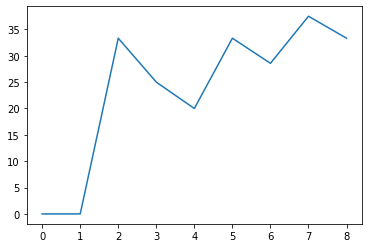

In [8]:
plt.plot(list)